<a href="https://colab.research.google.com/github/sayalibadole/Fake-news-Detector/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Project**

**Fake News Detector By Christopher Lendechy and Sayali Badole**

Date: 12th December, 2022

## **Introduction**

Fake news is false or misleading information that is typically used maliciously. In the last couple of years, fake news has become widespread issue across the internet, especially on social media sites. This type of news speads easily on social media due to how difficult it is to disguish fake news at a glance. 

This notebook contains several approaches to predict if a given news is fake or not. This “Fake News Detector” would identify if an article is trustworthy or not from its article title. Further, into the project, we would also attempt to identify if the news is likely to be fake based on its source and the number of re-tweets it gets.

For our dataset, we are using a fake news dataset from Kaggle based on FakeNewsNet. In this dataset, every entry represents a tweet containing an article headline, a URL linking to an actual article, the source of the article, how many re-tweets it has, and if the news is fake.This dataset is appropriate for our project because it contains both fake and real news from a variety of different topics and sources. Additionally, all of the fake news articles were verified by Politifact and Gossipcop, both known for fact-checking sources online.

Link to the dataset:  https://www.kaggle.com/datasets/algord/fake-news 

Creating a model that could help predict the legitimacy of a news article can be very valuable and can be used and integrated into any system for future use. 


## **Read the Data**

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers, Model, Input, callbacks
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras import backend as K 
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
pd.options.display.max_colwidth = 100
from tensorflow.keras.datasets import imdb
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from pandas.core.ops.array_ops import na_logical_op
from sklearn.model_selection import ParameterGrid

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir='/content/drive/MyDrive/FakeNewsNet.csv'
df= pd.read_csv(data_dir,low_memory=False)
np.random.seed(0)

Mounted at /content/drive


## **Initial Exploration**

Starting off with getting to know the data. Here are the first few rows of the dataset.

In [ ]:
df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video),http://toofab.com/2017/05/08/real-housewives-atlanta-kandi-burruss-rape-phaedra-parks-porsha-wil...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carpet looks,https://www.today.com/style/see-people-s-choice-awards-red-carpet-looks-t141832,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'One Tree Hill' Co-Star Hilarie Burton: 'Breyton 4eva',https://www.etonline.com/news/220806_sophia_bush_sends_sweet_birthday_message_to_one_tree_hill_c...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inappropriate relationship with AUNT,https://www.dailymail.co.uk/news/article-3365543/Colombian-music-star-sparks-rumours-inappropria...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Siders Shocked the World and Changed Pop Culture Forever,https://www.zerchoo.com/entertainment/gossip-girl-10-years-later-how-upper-east-siders-shocked-t...,www.zerchoo.com,38,1


We can see that there are 4 different columns, the first few rows gives us an idea about the type of data in the columns.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


We can see that the data consists of about 23K enteries/rows and 4 features/columns with string and integer data types

|Coloumn Name|Description|
|---|---|
|title	|title of the article
|news_url|URL of the news site
|source_domain	|web domain where article was posted
|tweet_num	|number of retweets for this article.
|real	|label column, where 1 is real and 0 is fake.

What is the average number of re-tweets a news article gets?

In [ ]:
df['tweet_num'].describe()

count    23196.000000
mean        88.956803
std        488.694592
min          0.000000
25%         11.000000
50%         37.000000
75%         65.000000
max      29060.000000
Name: tweet_num, dtype: float64

There is a big difference between max and mean/50% quartile, this could mean some sources are more popular than others.

What are the different news sources?

In [ ]:
df['source_domain'].value_counts()

people.com                1786
www.dailymail.co.uk        964
en.wikipedia.org           741
www.usmagazine.com         709
www.etonline.com           666
                          ... 
bioguide.congress.gov        1
dailyheadlines.net           1
www.duggarfamily.com         1
www.naturallycurly.com       1
flashnewscorner.com          1
Name: source_domain, Length: 2441, dtype: int64

How many unique values does each column in the dataset have?

In [ ]:
df.nunique()

title            21724
news_url         21658
source_domain     2441
tweet_num          825
real                 2
dtype: int64

An example news article title:

In [ ]:
df['title'][0]

"Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video)"

How balanced is the dataset?

About 1/3 of the dataset is fake news. Since it is fairly balanced and there are only 23K entries to work with, we will not be balacing the dataset

In [ ]:
df['real'].value_counts()

1    17441
0     5755
Name: real, dtype: int64

How many character long are these titles?

Since they are just article titles, the max length is not more than 200 characters long.

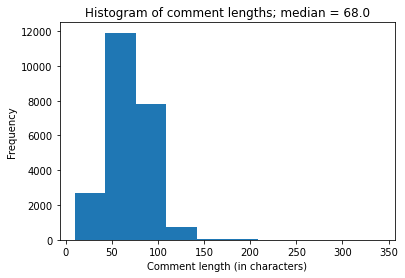

In [ ]:
df["title"].str.len().plot.hist()
median_len = df['title'].str.len().median()
plt.xlabel('Comment length (in characters)')
plt.title(f'Histogram of comment lengths; median = {median_len}');

Does the number of re-tweets an article gets relate to it being fake?

In [ ]:
df.groupby('real').apply(lambda d: d['tweet_num'].median())

real
0    13.0
1    44.0
dtype: float64

We can see that fake artiicles have fewer retweets.

What news websites spread the most fake news?

In [ ]:
fake_df=df[(df['real']==0)]
fake_df['source_domain'].value_counts()

hollywoodlife.com         460
people.com                216
www.dailymail.co.uk       194
radaronline.com           174
www.eonline.com           154
                         ... 
sffq.aviazione.biz          1
bieber.trendolizer.com      1
usa24info.com               1
www.nj.com                  1
flashnewscorner.com         1
Name: source_domain, Length: 971, dtype: int64

It can be seen that it's usually the celebrity based magazines and news channels that spread the most fake news. Some of these are at the top of the list also because they have more entries in the dataset.

## **Preprocessing**

In [ ]:
target = 'real'
predictors = 'title'

X = df[predictors].values
y = df[target].values

In [ ]:
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (23196,)
y shape: (23196,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16237,) (16237,)
(6959,) (6959,)


About 16K training data and 7K test data.

What is the baseline accuracy?

In [ ]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([ 4065, 12172]))
(array([0, 1]), array([1690, 5269]))


In [ ]:
counts = df['real'].value_counts()/df.shape[0]
print('baseline accuracy: {:0.4f}'.format(counts[1]))                      

baseline accuracy: 0.7519


# **Machine Learning**

We will be using different text classification techniques to build models that can predict if an article is fake or real. 

### **Set Models- Bag of words and it's variations**

> Unigram Bag-of-words Model

Our initial approach uses the bag of words model to see if we can perform better than 75% our baseline.

Our first step, would be to convert the text into vectors to feed it into the model. We tried various values of max_tokens, as big as 20K. However since the data is limited, 5K tokens were enough to give good accuracy.

In [ ]:
max_tokens = 5000
text_vectorization_1 = TextVectorization(max_tokens=max_tokens, output_mode="multi_hot")
text_vectorization_1.adapt(X_train)

In [ ]:
X_train_1= text_vectorization_1(X_train)

In [ ]:
X_test_1= text_vectorization_1(X_test)

In [ ]:
patience = 5 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=patience)


In [ ]:
K.clear_session()

In [ ]:
input_size = X_train_1.shape[1]

In [ ]:
model = models.Sequential()

model.add(layers.Dense(100, activation='relu', input_shape=(input_size,),kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_1, y_train, epochs=30, batch_size=128, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/30
89/89 [==============================] - 3s 22ms/step - loss: 0.6779 - accuracy: 0.7588 - val_loss: 0.5428 - val_accuracy: 0.8188
Epoch 2/30
89/89 [==============================] - 2s 20ms/step - loss: 0.5015 - accuracy: 0.8335 - val_loss: 0.4880 - val_accuracy: 0.8266
Epoch 3/30
89/89 [==============================] - 2s 20ms/step - loss: 0.4491 - accuracy: 0.8506 - val_loss: 0.4677 - val_accuracy: 0.8309
Epoch 4/30
89/89 [==============================] - 2s 23ms/step - loss: 0.4237 - accuracy: 0.8589 - val_loss: 0.4599 - val_accuracy: 0.8335
Epoch 5/30
89/89 [==============================] - 3s 28ms/step - loss: 0.4046 - accuracy: 0.8656 - val_loss: 0.4544 - val_accuracy: 0.8348
Epoch 6/30
89/89 [==============================] - 2s 27ms/step - loss: 0.3938 - accuracy: 0.8700 - val_loss: 0.4491 - val_accuracy: 0.8329
Epoch 7/30
89/89 [==============================] - 2s 21ms/step - loss: 0.3837 - accuracy: 0.8743 - val_loss: 0.4490 - val_accuracy: 0.8381
Epoch 8/30
89

In [ ]:
test_loss, test_acc = model.evaluate(X_test_1,y_test)
print(f"test accuracy: {test_acc: .3f}")

218/218 [==============================] - 1s 3ms/step - loss: 0.4670 - accuracy: 0.8273
test accuracy:  0.827


After experimenting with various parameters here's what we found:
- Batch Normalizing the data was infact reducing the accuracy by a lot.
- Dropout of 0.5 worked best, 0.2 and 0.7 were affecting the accuracy negatively
- Regularizing as L2 normalization worked better than L1
- Multiple dense layers and layer size of 100 worked better than 32,64,128 etc

Other parameters were also tuned like activation functions, optimizer and batch_size to achive this model with an overall accuracy that seemed to peak around 83%. Although it does perform better than baseline, accuracy seems to have plateaued. 

How about n-gram bag-of-word_models? 

> N-grams Bag-of-words model


This model uses the same structure as the one used in bag of words. However,with this model we are using up to 3 words per sequence to see if there can be any improvement.  

In [ ]:
text_vectorization_1 = TextVectorization(max_tokens = max_tokens, output_mode = "multi_hot", ngrams = 3)
text_vectorization_1.adapt(X_train)

In [ ]:
X_train_1 = text_vectorization_1(X_train)

In [ ]:
X_test_1 = text_vectorization_1(X_test)

In [ ]:
input_size = X_train_1.shape[1]

In [ ]:
K.clear_session()

In [ ]:
model = models.Sequential()

model.add(layers.Dense(100, activation='relu', input_shape=(input_size,),kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_1, y_train, epochs=30, batch_size=128, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/30
89/89 [==============================] - 3s 17ms/step - loss: 0.7583 - accuracy: 0.7501 - val_loss: 0.6107 - val_accuracy: 0.8095
Epoch 2/30
89/89 [==============================] - 1s 15ms/step - loss: 0.5656 - accuracy: 0.8187 - val_loss: 0.5303 - val_accuracy: 0.8296
Epoch 3/30
89/89 [==============================] - 1s 15ms/step - loss: 0.4887 - accuracy: 0.8507 - val_loss: 0.4925 - val_accuracy: 0.8303
Epoch 4/30
89/89 [==============================] - 2s 21ms/step - loss: 0.4511 - accuracy: 0.8558 - val_loss: 0.4750 - val_accuracy: 0.8315
Epoch 5/30
89/89 [==============================] - 2s 22ms/step - loss: 0.4231 - accuracy: 0.8633 - val_loss: 0.4771 - val_accuracy: 0.8331
Epoch 6/30
89/89 [==============================] - 2s 19ms/step - loss: 0.4051 - accuracy: 0.8692 - val_loss: 0.4580 - val_accuracy: 0.8344
Epoch 7/30
89/89 [==============================] - 1s 15ms/step - loss: 0.3912 - accuracy: 0.8727 - val_loss: 0.4610 - val_accuracy: 0.8333
Epoch 8/30
89

In [ ]:
test_loss, test_acc = model.evaluate(X_test_1,y_test)
print(f"test accuracy: {test_acc: .3f}")

218/218 [==============================] - 1s 4ms/step - loss: 0.4765 - accuracy: 0.8245
test accuracy:  0.825


Using a 3-gram model ends up giving around the same accuracy ~83%.  

How about using TF-IDF? Would adding a bit more information to this representation by counting how many times n-gram occurs, improve the accuracy?

> Bag-of-words using TF-IDF

The same model as our previous example, this time using TF-IDF. 

In [ ]:
text_vectorization_1 = TextVectorization(max_tokens = 5000, output_mode = "tf_idf", ngrams = 3)
text_vectorization_1.adapt(X_train)

In [ ]:
X_train_1 = text_vectorization_1(X_train)

In [ ]:
X_test_1 = text_vectorization_1(X_test)

In [ ]:
K.clear_session()

In [ ]:
model = models.Sequential()

model.add(layers.Dense(100, activation='relu', input_shape=(X_train_1.shape[1],)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))



model.add(layers.Dense(1, activation='sigmoid'))


In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_1, y_train, epochs=30, batch_size=128, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/30
89/89 [==============================] - 3s 17ms/step - loss: 0.8161 - accuracy: 0.5908 - val_loss: 0.5606 - val_accuracy: 0.7453
Epoch 2/30
89/89 [==============================] - 1s 15ms/step - loss: 0.6599 - accuracy: 0.6907 - val_loss: 0.5621 - val_accuracy: 0.7453
Epoch 3/30
89/89 [==============================] - 1s 14ms/step - loss: 0.5807 - accuracy: 0.7372 - val_loss: 0.4731 - val_accuracy: 0.7818
Epoch 4/30
89/89 [==============================] - 1s 15ms/step - loss: 0.4900 - accuracy: 0.7808 - val_loss: 0.4319 - val_accuracy: 0.8130
Epoch 5/30
89/89 [==============================] - 1s 15ms/step - loss: 0.4287 - accuracy: 0.8168 - val_loss: 0.4715 - val_accuracy: 0.8048
Epoch 6/30
89/89 [==============================] - 1s 15ms/step - loss: 0.3885 - accuracy: 0.8360 - val_loss: 0.4032 - val_accuracy: 0.8307
Epoch 7/30
89/89 [==============================] - 1s 14ms/step - loss: 0.3586 - accuracy: 0.8523 - val_loss: 0.4080 - val_accuracy: 0.8372
Epoch 8/30
89

In [ ]:
test_loss, test_acc = model.evaluate(X_test_1,y_test)
print(f"test accuracy: {test_acc: .3f}")

218/218 [==============================] - 1s 3ms/step - loss: 0.4453 - accuracy: 0.8327
test accuracy:  0.833


Bag-of-Word Model Conclusions: 

All these models once fine-tuned end up performing at around 83% test accuracy. 

Would it be helpful if we take word-order into consideration? From here, we are gonna change our approach and use sequence models to see if we can go beyond 83% accuracy. 

### **Sequence models- Word Embeddings**

> Embedding layer trained from scratch

We would be representing our input samples as sequences, vectorizing them and feeding these inputs to models.



In [ ]:
max_length = 200
max_tokens = 5000 
text_vectorization_3 = layers.TextVectorization(max_tokens=max_tokens,output_mode="int",output_sequence_length=max_length)

In [ ]:
text_vectorization_3.adapt(X_train)

In [ ]:
X_train_3= text_vectorization_3(X_train)

In [ ]:
X_test_3= text_vectorization_3(X_test)

In [ ]:
patience=5 
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=patience)  

In [ ]:
K.clear_session()

In [ ]:
inputs = Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=32,mask_zero=True)(inputs)
x=layers.Dense(64, activation="relu",kernel_regularizer=keras.regularizers.l1(0.001))(embedded)
x = layers.GRU(32,return_sequences=True)(x)
x = layers.GRU(32)(x)
x=layers.Dense(64, activation="relu",kernel_regularizer=keras.regularizers.l1(0.001))(x) 
                                                                         
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 32)          160000    
                                                                 
 dense (Dense)               (None, None, 64)          2112      
                                                                 
 gru (GRU)                   (None, None, 32)          9408      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [ ]:
model.fit(X_train_3,y_train, epochs=100,batch_size=64,callbacks=[early_stopping],validation_split=0.3, verbose=1)

Epoch 1/100
178/178 [==============================] - 62s 301ms/step - loss: 0.7770 - accuracy: 0.7719 - val_loss: 0.5568 - val_accuracy: 0.8222
Epoch 2/100
178/178 [==============================] - 49s 276ms/step - loss: 0.4677 - accuracy: 0.8480 - val_loss: 0.4651 - val_accuracy: 0.8321
Epoch 3/100
178/178 [==============================] - 47s 266ms/step - loss: 0.3960 - accuracy: 0.8689 - val_loss: 0.4470 - val_accuracy: 0.8327
Epoch 4/100
178/178 [==============================] - 54s 302ms/step - loss: 0.3622 - accuracy: 0.8786 - val_loss: 0.4396 - val_accuracy: 0.8325
Epoch 5/100
178/178 [==============================] - 49s 276ms/step - loss: 0.3395 - accuracy: 0.8834 - val_loss: 0.4449 - val_accuracy: 0.8274
Epoch 6/100
178/178 [==============================] - 52s 291ms/step - loss: 0.3254 - accuracy: 0.8889 - val_loss: 0.4595 - val_accuracy: 0.8319
Epoch 7/100
178/178 [==============================] - 51s 285ms/step - loss: 0.3165 - accuracy: 0.8890 - val_loss: 0.4506 -

In [ ]:
test_loss, test_acc = model.evaluate(X_test_3, y_test)
print(f"test accuracy: {test_acc: .3f}")

218/218 [==============================] - 11s 49ms/step - loss: 0.4679 - accuracy: 0.8248
test accuracy:  0.825


For this manually defined word embedding model, max_length of 200 worked the best, this could be because it is the average number of characters in the title of the dataset. Apart from this, few other observations made were:
- Stacked GRU performed better than any other neural network
- Dense layers at the start of the model (before GRU) helped improve the model
- These combinations of 32 and 64 layer sizes increased the accuracy
- L1 normalization drastically improved the accuracy 
- A lower batch size of 64 worked better unlike for the bag-of-words model
-Padding and masking in the embedding layer also improved the model by some extent.

Other parameters like Batch Normalization, Bidirectional layers, adding more layers negatively impacted the model.

Even word embedding models could not go beyond th 83% accuracy mark. Since there is not much data to train these embeddings on, we could use already learned embeddings to see if it could work better with our dataset. 

> Predefined Embedding Model- GloVe

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-12-13 04:11:15--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-13 04:11:15--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-13 04:11:16--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt" 

In [ ]:
embeddings_index = {} 
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
  
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
embedding_dim = 100 
  
vocabulary = text_vectorization_3.get_vocabulary()            
word_index = dict(zip(vocabulary, range(len(vocabulary))))   
 
embedding_matrix = np.zeros((max_tokens, embedding_dim))     
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:                         
        embedding_matrix[i] = embedding_vector   

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

In [ ]:
K.clear_session()

In [ ]:
inputs = Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x=layers.Dense(64, activation="relu",kernel_regularizer=keras.regularizers.l1(0.001))(embedded)
x = layers.GRU(32,return_sequences=True)(x)
x = layers.GRU(32)(x)
x=layers.Dense(64, activation="relu",kernel_regularizer=keras.regularizers.l1(0.001))(x) 
                                                                         
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         500000    
                                                                 
 dense (Dense)               (None, None, 64)          6464      
                                                                 
 gru (GRU)                   (None, None, 32)          9408      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0     

In [ ]:
model.fit(X_train_3,y_train, epochs=100,batch_size=64,callbacks=[early_stopping],validation_split=0.3, verbose=1)

Epoch 1/100
178/178 [==============================] - 66s 317ms/step - loss: 1.0101 - accuracy: 0.7586 - val_loss: 0.7720 - val_accuracy: 0.7785
Epoch 2/100
178/178 [==============================] - 55s 307ms/step - loss: 0.6765 - accuracy: 0.7868 - val_loss: 0.6198 - val_accuracy: 0.8003
Epoch 3/100
178/178 [==============================] - 48s 272ms/step - loss: 0.5984 - accuracy: 0.7955 - val_loss: 0.5939 - val_accuracy: 0.7863
Epoch 4/100
178/178 [==============================] - 52s 291ms/step - loss: 0.5654 - accuracy: 0.8039 - val_loss: 0.5473 - val_accuracy: 0.8021
Epoch 5/100
178/178 [==============================] - 50s 282ms/step - loss: 0.5383 - accuracy: 0.8125 - val_loss: 0.5218 - val_accuracy: 0.8183
Epoch 6/100
178/178 [==============================] - 50s 282ms/step - loss: 0.5233 - accuracy: 0.8128 - val_loss: 0.5069 - val_accuracy: 0.8140
Epoch 7/100
178/178 [==============================] - 49s 277ms/step - loss: 0.5100 - accuracy: 0.8154 - val_loss: 0.5057 -

In [ ]:
test_loss, test_acc = model.evaluate(X_test_3, y_test)
print(f"test accuracy: {test_acc: .3f}")

218/218 [==============================] - 10s 47ms/step - loss: 0.4813 - accuracy: 0.8225
test accuracy:  0.823


We used the GloVe embeddings for this dataset since it has over 400K work vectors and one of the most popular ones. Identical to the previous model this model had 100 dimensional pretrained embeddings instead of learned embeddings. 

However it did not work as expected, this could be because either the data was suffienct for the previous embedding model to learn or because these predefined embeddings do not work for this specific dataset.

Could the concept of "attention" help recognize more important features? 

### **The Transformer Architecture**

We would be using a transformer encoder to make text classifications.

> Transformer Encoder

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                         
        self.dense_dim = dense_dim                         
        self.num_heads = num_heads                         
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim,activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    def call(self, inputs, mask=None):                    
        if mask is not None:                              
            mask = mask[:, tf.newaxis, :]                 
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)
  
    def get_config(self):                                 
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [ ]:
K.clear_session()

In [ ]:
vocab_size = 5000
embed_dim = 256
num_heads = 3
dense_dim = 32

inputs = keras.Input(shape=(None,), dtype="int64")
x = layers.Embedding(vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         1280000   
                                                                 
 transformer_encoder (Transf  (None, None, 256)        806688    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257   

In [ ]:
model.fit(X_train_3,y_train, epochs=100,batch_size=64,callbacks=[early_stopping],validation_split=0.3, verbose=1)

Epoch 1/100
178/178 [==============================] - 10s 48ms/step - loss: 0.5737 - accuracy: 0.7516 - val_loss: 0.4338 - val_accuracy: 0.8266
Epoch 2/100
178/178 [==============================] - 8s 46ms/step - loss: 0.3829 - accuracy: 0.8390 - val_loss: 0.3988 - val_accuracy: 0.8317
Epoch 3/100
178/178 [==============================] - 8s 46ms/step - loss: 0.3335 - accuracy: 0.8604 - val_loss: 0.3840 - val_accuracy: 0.8362
Epoch 4/100
178/178 [==============================] - 8s 47ms/step - loss: 0.2993 - accuracy: 0.8778 - val_loss: 0.4198 - val_accuracy: 0.8362
Epoch 5/100
178/178 [==============================] - 8s 47ms/step - loss: 0.2810 - accuracy: 0.8851 - val_loss: 0.4173 - val_accuracy: 0.8325
Epoch 6/100
178/178 [==============================] - 8s 47ms/step - loss: 0.2666 - accuracy: 0.8934 - val_loss: 0.4278 - val_accuracy: 0.8325
Epoch 7/100
178/178 [==============================] - 8s 47ms/step - loss: 0.2542 - accuracy: 0.8934 - val_loss: 0.4106 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(X_test_3, y_test)
print(f"test accuracy: {test_acc: .3f}")

218/218 [==============================] - 2s 9ms/step - loss: 0.4238 - accuracy: 0.8339
test accuracy:  0.834


This model applies the concepts of multi-headed attention, with 3 inputs, combinations of dense layers and layer normalization. We just need the encoder part of the architecture to solve text classification problems.

Again, about the same accuracy. Would giving a word order using positional embedding help?

> Transformer Encoder with Positional Embeddings

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [ ]:
vocab_size = 5000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 64

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()
model.fit(X_train_3,y_train, epochs=100,batch_size=64,callbacks=[early_stopping],validation_split=0.3, verbose=1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        1433600   
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder (Transf  (None, None, 256)        560192    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

In [ ]:
test_loss, test_acc = model.evaluate(X_test_3, y_test)
print(f"test accuracy: {test_acc: .3f}")

218/218 [==============================] - 2s 8ms/step - loss: 0.5347 - accuracy: 0.8086
test accuracy:  0.809


Adding order to the model does not help the model. Let's try tuning it.

> Tuned Transformer Model using Grid Search

In [ ]:
def get_model():
  vocab_size = 5000
  sequence_length = 600
  embed_dim = 256
  num_heads = 2
  dense_dim = 64

  inputs = keras.Input(shape=(None,), dtype="int64")
  x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
  x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
  x = layers.GlobalMaxPooling1D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1, activation="sigmoid")(x)
  model = keras.Model(inputs, outputs)
  return model

In [ ]:
default_params = {
    'batch_size': 128,
    'embed_dim': 256,
    'num_heads': 3,
    'dense_dim' : 32
}

In [ ]:
def evaluate_params(params, verbose=1):
    """ Return validation accuracy for a model built and trained using the given parameters.
    args:
        params: a Python dictionary
    """

    # default parameters are used if not supplied
    pars = default_params.copy()
    pars.update(params)

    batch_size = pars['batch_size']
    embed_dim = pars['embed_dim'] 
    num_head =  pars["num_heads"],
    dense_dim = pars['dense_dim']
 

    model = get_model()
    model.compile(optimizer='rmsprop',
              loss="binary_crossentropy",
              metrics=["accuracy"])
    
    history = model.fit(X_train_3, y_train, epochs=30, callbacks=[early_stopping], batch_size=batch_size, 
                        validation_split=0.3, verbose=verbose)
    mean_acc = np.mean(history.history['val_accuracy'][-2:])   

    return pars, mean_acc, history

In [ ]:
def grid_search(param_grid, verbose=1):

    params_list = []
    acc_list = []
    for params in ParameterGrid(param_grid):
        print(f"params: {params}")
        pars, acc, history = evaluate_params(params, verbose=verbose)

        params_list.append(pars)
        acc_list.append(acc)

    return params_list, acc_list

In [ ]:
param_grid = {'batch_size': [16,32,128],'embed_dim': [256,128], 'num_heads': [2,3,6], 'dense_dim' : [16,32,64]}
results = grid_search(param_grid)

params: {'batch_size': 16, 'dense_dim': 16, 'embed_dim': 256, 'num_heads': 2}
Epoch 1/30
711/711 [==============================] - 11s 13ms/step - loss: 0.5069 - accuracy: 0.7846 - val_loss: 0.4867 - val_accuracy: 0.7566
Epoch 2/30
711/711 [==============================] - 9s 13ms/step - loss: 0.3721 - accuracy: 0.8496 - val_loss: 0.4033 - val_accuracy: 0.8292
Epoch 3/30
711/711 [==============================] - 9s 13ms/step - loss: 0.3346 - accuracy: 0.8688 - val_loss: 0.4370 - val_accuracy: 0.8132
Epoch 4/30
711/711 [==============================] - 9s 13ms/step - loss: 0.3089 - accuracy: 0.8783 - val_loss: 0.4282 - val_accuracy: 0.8290
Epoch 5/30
711/711 [==============================] - 9s 13ms/step - loss: 0.2926 - accuracy: 0.8883 - val_loss: 0.4261 - val_accuracy: 0.8198
Epoch 6/30
711/711 [==============================] - 9s 13ms/step - loss: 0.2841 - accuracy: 0.8914 - val_loss: 0.4285 - val_accuracy: 0.8237
Epoch 7/30
711/711 [==============================] - 9s 13ms/s

In [ ]:
def scores_to_dataframe(scores):
    """ Return hyperparameters and scores in a data frame. """
    
    params_list, acc_list = scores
    
    params = pd.DataFrame(params_list)
    accs = pd.Series(acc_list)
    scores_df = pd.concat([params, accs], axis=1)
    
    return scores_df

In [ ]:
scores_to_dataframe(results)

,batch_size,embed_dim,num_heads,dense_dim,0
0,16,256,2,16,0.824405
1,16,256,3,16,0.827278
2,16,256,6,16,0.830768
3,16,128,2,16,0.822660
4,16,128,3,16,0.825739
5,16,128,6,16,0.819273
6,16,256,2,32,0.829844
7,16,256,3,32,0.826765
8,16,256,6,32,0.819889
9,16,128,2,32,0.822968


The paramters we choose to tune for the Grid search were batch size, embedding dimensions, number of inputs to the multi head attention and layer size.

Other parameters like vocab_size, dropout, batch normalization, optimizer, activation functions, sequence length and l1/l2 were manually tested. 

- Just like previous models normalizing the data did not help
- After trying various sequence length values 600 was the only one that gave a decent accuracy. Any other length would drastically drop the accuracy.

From the accuracy scores obtained after grid seach, it can be seen that- even after trying all possible combinations of paramters, the best we could get is a validation accuracy of about 82.8%. Further, applying this tuned model on test data:

In [ ]:
K.clear_session()

In [ ]:
vocab_size = 5000
sequence_length = 600
embed_dim = 128
num_heads = 6
dense_dim = 64

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()
model.fit(X_train_3,y_train, epochs=100,batch_size=16,callbacks=[early_stopping],validation_split=0.3, verbose=1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 128)        716800    
 ionalEmbedding)                                                 
                                                                 
 transformer_encoder (Transf  (None, None, 128)        412736    
 ormerEncoder)                                                   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

In [ ]:
test_loss, test_acc = model.evaluate(X_test_3, y_test)
print(f"test accuracy: {test_acc: .3f}")

218/218 [==============================] - 2s 9ms/step - loss: 0.4599 - accuracy: 0.8268
test accuracy:  0.827


We could improve the accuracy from 80% to 82%. Although it's the better performing model, it performs only slightly more accurate than our previous models. 

## **Basic ML techniques**

Can we predict if the news is fake or not from its source and number of re-tweets?

> KNN Classification


In [ ]:
df_knn=df.drop(['title','news_url'],axis=1)

In [ ]:
df_knn = pd.get_dummies(df_knn, drop_first=True)

In [ ]:
df_knn.shape

(23196, 2442)

In [ ]:
target='real' 
predictors = list(df_knn.columns)
predictors.remove(target)

X_knn = df_knn[predictors].values
y_knn = df_knn[target].values

X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, test_size=0.30, random_state=0)

In [ ]:
quant_features = [0]
xform = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), quant_features)
    ],
    remainder='passthrough'  # do nothing with other columns
)

X_train_knn = xform.fit_transform(X_train_knn)
X_test_knn  = xform.transform(X_test_knn)

In [ ]:
vals, counts = np.unique(y_train_knn, return_counts=True)
target_mode = vals[counts.argmax()]
baseline= (y_train_knn==target_mode).mean() 
print('Baseline Accuracy: {:.3f}'.format(baseline))

Baseline Accuracy: 0.749


In [ ]:
clf = KNeighborsClassifier()

In [ ]:
accs = cross_val_score(clf, X_train_knn, y_train_knn, scoring="accuracy", cv=10).mean()
print('Cross-validation accuracy: {:.3f}'.format(accs))

Cross-validation accuracy: 0.798


In [ ]:
cv_accuracy = []
ks = range(1,20,2)
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    accs = cross_val_score(knn, X_train_knn, y_train_knn, scoring="accuracy", cv=10)
    cv_accuracy.append(accs.mean())

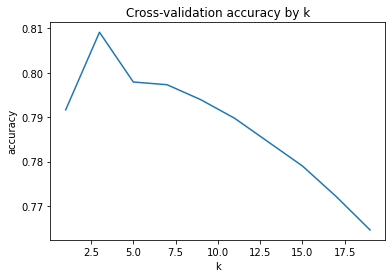

In [ ]:
plt.plot(ks, cv_accuracy)
plt.title('Cross-validation accuracy by k')
plt.xlabel('k')
plt.ylabel('accuracy');

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_knn, y_knn)
y_pred = clf.predict(X_knn)

accs = cross_val_score(clf, X_train_knn, y_train_knn, scoring="accuracy", cv=10).mean()
print('Cross-validation accuracy: {:.3f}'.format(accs))

Cross-validation accuracy: 0.809


In [ ]:
test_accuracy = clf.score(X_test_knn,y_test_knn)
print('Test accuracy: {:.3f}'.format(test_accuracy))

Test accuracy: 0.809


Applying a basic knn classifier to predict fake news from source of the article and the number of re-tweets gave an accuracy of 80% from the baseline.

This model was scaled, transformed and tuned for the value of K to find the best model. It can be seen from the graph that k value of 3 gave the maximum accuracy.

------

## **Conclusions**


To conclude, we created various models to predict the authenticity of a news article from its title and learned a lot about not only the techniques used but also the dataset, and the possible solutions that can be made in the future. 

An interesting pattern noticed with this dataset was that it does not work that well with the order of the words. Whenever the "order" was used in the dataset like sequence models and positional embeddings- accuracy was affected. 

One possible reason for this could be because- news article titles contain the fewest possible words to describe the contents of the actual article. In this case, the order of words does not matter as much. 

Considering the predictor were short sentences, training the models to learn based on word frequency and order- reaching the 83-84 accuracy mark was the best effort made. 

In the future, this dataset and the conclusions made from this project can also be applied to more complex and advanced deep-learning techniques to get better accuracy and value by integrating those models into real-world systems
